In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

### Data Loading

In [2]:
import warnings
warnings.filterwarnings('ignore')
df= pd.read_csv('../data/raw/accepted_2007_to_2017.csv', low_memory=True)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,38098114,NaN,15000.0,15000.0,15000.0,60 months,12.39,336.64,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,36805548,NaN,10400.0,10400.0,10400.0,36 months,6.99,321.08,A,A3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,37842129,NaN,21425.0,21425.0,21425.0,60 months,15.59,516.36,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,37612354,NaN,12800.0,12800.0,12800.0,60 months,17.14,319.08,D,D4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,37662224,NaN,7650.0,7650.0,7650.0,36 months,13.66,260.20,C,C3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.shape

(1646801, 150)

The dataset has many features. We first focus on limiting the feature space based on data dictionary, domain knowledge and intuition, then move on to eda

In [4]:
#Target variable
df['loan_status'].value_counts()

loan_status
Current                                                788950
Fully Paid                                             646902
Charged Off                                            168084
Late (31-120 days)                                      23763
In Grace Period                                         10474
Late (16-30 days)                                        5786
Does not meet the credit policy. Status:Fully Paid       1988
Does not meet the credit policy. Status:Charged Off       761
Default                                                    70
Name: count, dtype: int64

In [5]:
#Selecting data where loan is either fully paid or charged off
df= df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
df['loan_status'].value_counts(normalize=True, dropna=False)

loan_status
Fully Paid     0.793758
Charged Off    0.206242
Name: proportion, dtype: float64

79% of the data is fully paid and 21% charged off. The dataset is somewhat imbalanced

In [6]:
#Preparing the target column
df['charged_off']= (df['loan_status'] == 'Charged Off').apply(np.uint8)

In [7]:
df.drop('loan_status', axis=1, inplace=True)

In [8]:
#Removing features with more than 30% missing values
missing_fractions= df.isnull().mean().sort_values(ascending=False)
missing_fractions.head()

member_id                                     1.000000
next_pymnt_d                                  1.000000
orig_projected_additional_accrued_interest    0.999876
sec_app_mths_since_last_major_derog           0.999628
hardship_length                               0.999275
dtype: float64

In [9]:
drop_list= sorted(list(missing_fractions[missing_fractions > 0.3].index))
df.drop(labels= drop_list, axis=1, inplace=True)

In [10]:
df.shape

(814986, 92)

In [11]:
#Keeping data that is based on domain knowledge according to the data dict
keep_list= ['charged_off','funded_amnt','addr_state', 'annual_inc', \
'application_type','dti', 'earliest_cr_line', 'emp_length',\
'emp_title', 'fico_range_high',\
'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', \
'installment', 'int_rate', 'loan_amnt',\
'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', \
'purpose', 'revol_bal', 'revol_util', \
'sub_grade', 'term', 'title', 'total_acc',\
'verification_status', 'zip_code','last_pymnt_amnt',\
'num_actv_rev_tl', 'mo_sin_rcnt_rev_tl_op',\
'mo_sin_old_rev_tl_op',"bc_util","bc_open_to_buy",\
"avg_cur_bal","acc_open_past_24mths" ]

In [12]:
drop_list= [col for col in df.columns if col not in keep_list]

df.drop(labels=drop_list, axis=1, inplace=True)

df.shape

(814986, 39)

In [13]:
#Correlation handling -keeping moderate to strong relationship
correlation= df.select_dtypes(exclude='object').corr()
corr_co= abs(correlation['charged_off'])
drop_list= sorted(list(corr_co[corr_co < 0.03].index))
drop_list

['pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'total_acc']

In [14]:
df.drop(labels=drop_list, axis=1, inplace=True)

In [15]:
df.shape

(814986, 35)

### Feature Engineering and EDA

### Univariate Analysis - Categorical Features

In [16]:
df.select_dtypes(include='object').describe()

,id,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,application_type
count,814986,814986,814986,814986,766415,772733,814986,814986,814986,807067,814986,814986,814986,814986,814986
unique,814986,2,7,35,280473,11,6,3,14,60297,925,51,712,2,2
top,38098114,36 months,B,B3,Teacher,10+ years,MORTGAGE,Source Verified,debt_consolidation,Debt consolidation,945xx,CA,Aug-2001,f,Individual
freq,1,618460,235225,51309,11351,264873,406866,293897,481652,371874,9517,124204,6024,413678,811207


***id*** is unique and irrelevant for modeling.

***emp_title and title*** also contains a high number of unique features, which can cause high cardinality and lead to overfitting.

In [17]:
df.drop(['id', 'emp_title', 'zip_code', 'title'], axis=1, inplace=True)

In [18]:
df['term'].unique()

array([' 60 months', ' 36 months'], dtype=object)

In [19]:
df['term']= df['term'].apply(lambda s: np.int8(s.split()[0]))

In [20]:
df.groupby('term')['charged_off'].value_counts(normalize=True)

term  charged_off
36    0              0.834290
      1              0.165710
60    0              0.666207
      1              0.333793
Name: proportion, dtype: float64

Loans with 5 year periods are more than twice as likely to charge-off as loans with three year periods. The feature is important for prediction.

In [21]:
df['emp_length'].unique()

array(['10+ years', '8 years', '6 years', '< 1 year', '2 years',
       '9 years', '7 years', '3 years', '1 year', nan, '4 years',
       '5 years'], dtype=object)

In [22]:
df['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
df['emp_length'].replace(to_replace='< 1 year', value='0 years', inplace=True)

In [23]:
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
    
df['emp_length']= df['emp_length'].apply(emp_length_to_int)

In [24]:
charged_off_rates= df.groupby('emp_length')['charged_off'].value_counts(normalize=True).loc[:,1]
charged_off_rates

emp_length
0.0     0.212724
1.0     0.212203
2.0     0.203366
3.0     0.205711
4.0     0.202535
5.0     0.200483
6.0     0.199801
7.0     0.202248
8.0     0.210482
9.0     0.209592
10.0    0.194825
Name: proportion, dtype: float64

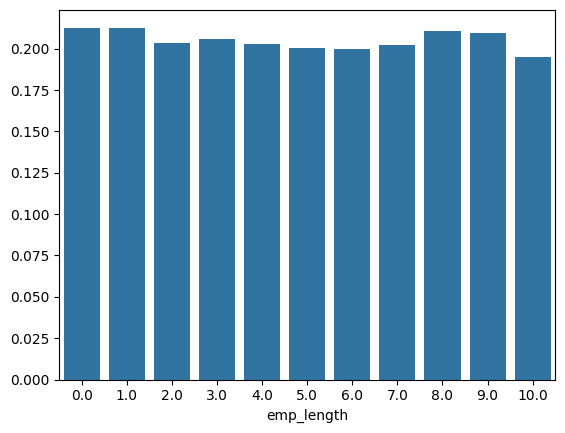

In [25]:
sns.barplot(x=charged_off_rates.index, y=charged_off_rates.values);

Loan status does not appear to vary much with employment length on average, hence feature is not important

In [26]:
df.drop('emp_length', axis=1, inplace=True)

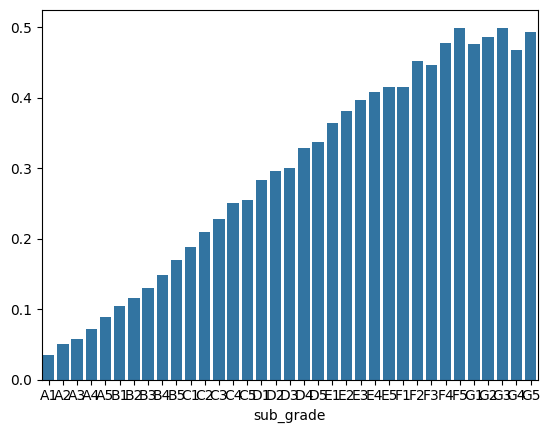

In [27]:
#sub-grade feature
charged_off_rates= df.groupby('sub_grade')['charged_off'].value_counts(normalize=True).loc[:,1]

sns.barplot(x=charged_off_rates.index, y=charged_off_rates.values);

There's a clear trend of high pobabiliy of charge-off as the sub-grade worsens, thus this is a key feature

In [28]:
df.select_dtypes(include='object').columns.tolist()

['grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'application_type']

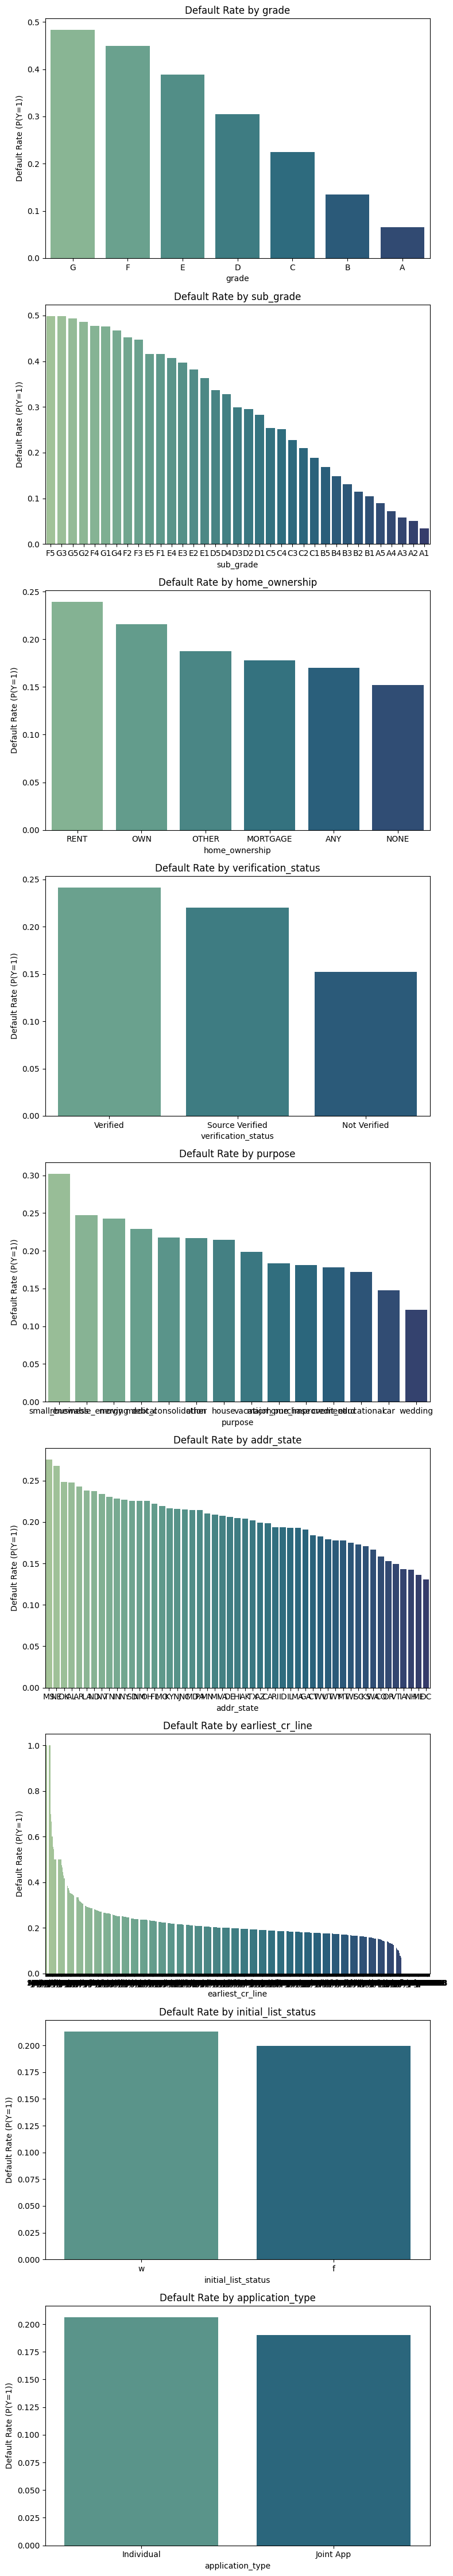

In [29]:
#Examining conditional probabilities of key categorical features
import warnings
warnings.filterwarnings('ignore')
categorical_columns= df.select_dtypes(include='object').columns.tolist()

fig, axes = plt.subplots(len(categorical_columns), 1, figsize=(8, 5 * len(categorical_columns)))

for i, col in enumerate(categorical_columns):
    default_rate = df.groupby(col)['charged_off'].mean().reset_index().sort_values("charged_off", ascending=False)

    sns.barplot(x=col, y="charged_off", data=default_rate, ax=axes[i], palette="crest")
    axes[i].set_title(f'Default Rate by {col}')
    axes[i].set_ylabel("Default Rate (P(Y=1))")
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()


### Univariate analysis - Numerical Features

In [30]:
df.drop('charged_off', axis=1).select_dtypes(exclude='object').describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,814986.0,14315.458210,8499.799241,500.00,8000.0000,12000.000,20000.00,40000.00
funded_amnt,814986.0,14301.566929,8492.964986,500.00,8000.0000,12000.000,20000.00,40000.00
term,814986.0,41.787368,10.266613,36.00,36.0000,36.000,36.00,60.00
int_rate,814986.0,13.490993,4.618486,5.32,9.9900,13.110,16.29,30.99
installment,814986.0,436.749624,255.732093,4.93,251.4000,377.040,576.29,1714.54
annual_inc,814986.0,75230.389095,65243.729443,0.00,45000.0000,65000.000,90000.00,9550000.00
dti,814950.0,17.867719,8.856477,-1.00,11.6400,17.360,23.63,999.00
fico_range_low,814986.0,695.603151,31.352251,625.00,670.0000,690.000,710.00,845.00
fico_range_high,814986.0,699.603264,31.352791,629.00,674.0000,694.000,714.00,850.00
open_acc,814986.0,11.521099,5.325064,0.00,8.0000,11.000,14.00,90.00


In [31]:
from scipy.stats import skew, kurtosis
skew_kurtosis= pd.DataFrame({
    'skew': df.select_dtypes(exclude='object').apply(lambda x: skew(x)),
    'kurtosis': df.select_dtypes(exclude='object').apply(lambda x: kurtosis(x)),
})
skew_kurtosis

,skew,kurtosis
loan_amnt,0.763633,-0.109363
funded_amnt,0.765968,-0.102879
term,1.210260,-0.535271
int_rate,0.571330,0.187449
installment,0.992396,0.764194
annual_inc,44.482960,4689.744654
dti,NaN,NaN
fico_range_low,1.301430,1.737071
fico_range_high,1.301599,1.738300
open_acc,1.273335,3.281071


***annual_inc*** contains a huge number, confirming presence of extreme outliers and long tail of distribution. This can be confirmed in the data description, as annual income ranges from 0-9.5 million dollars, and a median of 65k. Because of the large values, log transformation will be applied to the variable.

In [32]:
df['log_annual_inc']= df['annual_inc'].apply(lambda x: np.log10(x+1))
df.drop('annual_inc', axis=1, inplace=True)

In [33]:
df[['fico_range_low', 'fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


The correlation between fico columns is 1, thus we keep only one feature, that is, the average.

In [34]:
df['fico_score']= 0.5 * df['fico_range_low'] + 0.5*df['fico_range_high']
df.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

In [35]:
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y')

current_date = pd.to_datetime('today')
df['credit_age_months'] = (current_date.year - df['earliest_cr_line'].dt.year) * 12 + \
                          (current_date.month - df['earliest_cr_line'].dt.month)

df['credit_age_years'] = df['credit_age_months'] / 12

df= df.drop(columns= ['earliest_cr_line'])


In [36]:
df.shape

(814986, 30)

In [39]:
train, test= train_test_split(df, test_size=0.3, random_state=42, stratify=y)

In [43]:
train.to_csv('../data/interim/train.csv', index=False)
test.to_csv('../data/interim/test.csv', index=False)